# PSG-IPA Disagreement-Aware Sleep Scoring (Colab)

This notebook builds a practical sleep-scoring workflow on top of the PSG-IPA dataset:

1. Train a sleep stage classifier from raw PSG features.
2. Quantify inter-scorer disagreement per epoch.
3. Train an ambiguity model to predict when epochs are likely contentious.
4. Combine model confidence + ambiguity risk to decide:
   - **Auto-accept** (high-confidence, low-risk)
   - **Send to human review** (uncertain or high-risk)

The goal is not only accuracy, but a **safe semi-automation pipeline** that knows when to ask for help.

In [1]:
# Environment setup note
# Dependencies are installed externally before execution in this local run.
print('Dependency install cell skipped (already installed in current environment).')

Dependency install cell skipped (already installed in current environment).


In [2]:
import os
import re
import json
import glob
import math
import shutil
import pathlib
import requests
import warnings
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import mne
import pyedflib
from scipy.signal import welch

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    cohen_kappa_score,
    f1_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)

# Paths
# Use /content in Colab, and a local folder when running elsewhere.
if 'google.colab' in str(os.environ.get('COLAB_RELEASE_TAG', '')) or pathlib.Path('/content').exists():
    base_root = pathlib.Path('/content')
else:
    base_root = pathlib.Path.cwd()

PROJECT_DIR = base_root / 'psg_ipa_project'
DATA_DIR = PROJECT_DIR / 'data'
RESULTS_DIR = PROJECT_DIR / 'results'
for p in [PROJECT_DIR, DATA_DIR, RESULTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

BASE_URL = 'https://physionet.org/files/psg-ipa/1.0.0'
TASK_FOLDER = 'Sleep_stages'
TASK_ID = 'SleepStages'  # matches file naming in this task

print('Project directory:', PROJECT_DIR)
print('Data directory   :', DATA_DIR)

Project directory: /Users/alphaskynet/Downloads/Projects Feb 2026/untitled folder/psg_ipa_project
Data directory   : /Users/alphaskynet/Downloads/Projects Feb 2026/untitled folder/psg_ipa_project/data


In [3]:
def download_file(url: str, out_path: pathlib.Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    if out_path.exists() and out_path.stat().st_size > 0:
        return
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    with open(out_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)


def list_remote_records(task_folder: str):
    # PhysioNet provides a single top-level RECORDS file.
    records_url = f"{BASE_URL}/RECORDS"
    txt = requests.get(records_url, timeout=60).text
    lines = [ln.strip() for ln in txt.splitlines() if ln.strip()]
    raw_edf = [ln for ln in lines if ln.startswith(f"{task_folder}/PSG/") and ln.endswith('.edf')]
    return sorted(raw_edf)


def list_directory_files(url: str):
    # Parse simple directory index pages exposed by PhysioNet.
    html = requests.get(url, timeout=60).text
    links = re.findall(r'href="([^"]+)"', html)
    out = []
    for link in links:
        if link in ('../',):
            continue
        if link.endswith('/'):
            continue
        out.append(link)
    return sorted(out)


def parse_stage_label(text: str):
    t = str(text).strip().lower()
    # Typical EDF+ stage descriptions
    mapping = {
        'sleep stage w': 'W',
        'sleep stage n1': 'N1',
        'sleep stage n2': 'N2',
        'sleep stage n3': 'N3',
        'sleep stage r': 'R',
        'sleep stage ?': 'UNK'
    }
    if t in mapping:
        return mapping[t]

    # Fallbacks if labels are abbreviated
    short_map = {
        'w': 'W', 'wake': 'W',
        'n1': 'N1', 's1': 'N1',
        'n2': 'N2', 's2': 'N2',
        'n3': 'N3', 's3': 'N3', 's4': 'N3',
        'r': 'R', 'rem': 'R'
    }
    t2 = re.sub(r'[^a-z0-9?]+', '', t)
    return short_map.get(t2, 'UNK')


def read_edf_annotations(edf_path: pathlib.Path):
    # Returns dataframe: onset_sec, duration_sec, label
    f = pyedflib.EdfReader(str(edf_path))
    onsets, durations, texts = f.readAnnotations()
    f.close()
    df = pd.DataFrame({
        'onset_sec': np.asarray(onsets, dtype=float),
        'duration_sec': np.asarray(durations, dtype=float),
        'label': [str(t) for t in texts]
    })
    return df


def get_lights_window(ann_df: pd.DataFrame):
    # Search common variants in annotation text
    low = ann_df['label'].str.lower()
    off_mask = low.str.contains('lights?\s*off')
    on_mask = low.str.contains('lights?\s*on')

    if off_mask.any() and on_mask.any():
        t_off = float(ann_df.loc[off_mask, 'onset_sec'].min())
        t_on = float(ann_df.loc[on_mask, 'onset_sec'].max())
        if t_on > t_off:
            return t_off, t_on

    # fallback to full recording span covered by annotations
    t0 = float(ann_df['onset_sec'].min())
    t1 = float((ann_df['onset_sec'] + ann_df['duration_sec'].clip(lower=0)).max())
    return t0, t1


def stage_timeline_from_annotations(ann_df: pd.DataFrame, epoch_sec=30):
    df = ann_df.copy()
    df['stage'] = df['label'].map(parse_stage_label)
    stage_df = df[df['stage'] != 'UNK'].copy()
    if stage_df.empty:
        return pd.DataFrame(columns=['epoch_idx', 'stage'])

    t_start, t_end = get_lights_window(ann_df)
    n_epochs = int(math.floor((t_end - t_start) / epoch_sec))
    epochs = []

    # For each epoch, assign stage with maximum overlap
    for e in range(n_epochs):
        e0 = t_start + e * epoch_sec
        e1 = e0 + epoch_sec

        overlaps = []
        for _, row in stage_df.iterrows():
            a0 = float(row['onset_sec'])
            a1 = float(row['onset_sec'] + max(row['duration_sec'], 0.0))
            ov = max(0.0, min(e1, a1) - max(e0, a0))
            if ov > 0:
                overlaps.append((ov, row['stage']))

        if len(overlaps) == 0:
            epochs.append((e, 'UNK'))
        else:
            overlaps.sort(reverse=True, key=lambda x: x[0])
            epochs.append((e, overlaps[0][1]))

    return pd.DataFrame(epochs, columns=['epoch_idx', 'stage'])

In [4]:
# Download sleep staging PSG + manual expert annotation EDF files.
# This avoids full-dataset download while keeping enough data for the pipeline.
MAX_RECORDINGS = 1

raw_records = list_remote_records(TASK_FOLDER)[:MAX_RECORDINGS]
selected_sn = [re.findall(r'(SN\d+)_SleepStages\.edf', pathlib.Path(r).name)[0] for r in raw_records]
print('Selected recordings:', selected_sn)

# Build annotation file list from PhysioNet directory index.
manual_ann_names = list_directory_files(f"{BASE_URL}/{TASK_FOLDER}/Annotations/manual/")
manual_ann_edf = [n for n in manual_ann_names if n.endswith('.edf') and any(n.startswith(sn + '_SleepStages_manual_') for sn in selected_sn)]

selected_files = raw_records + [f"{TASK_FOLDER}/Annotations/manual/{n}" for n in manual_ann_edf]
print('Files to download:', len(selected_files))

for rel in tqdm(selected_files):
    src = f"{BASE_URL}/{rel}"
    dst = DATA_DIR / rel
    download_file(src, dst)

print('Download done. Local task path:', DATA_DIR / TASK_FOLDER)

Selected recordings: ['SN1']


Files to download: 13


  0%|          | 0/13 [00:00<?, ?it/s]

Download done. Local task path: /Users/alphaskynet/Downloads/Projects Feb 2026/untitled folder/psg_ipa_project/data/Sleep_stages


In [5]:
STAGE_TO_INT = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'R': 4}
INT_TO_STAGE = {v: k for k, v in STAGE_TO_INT.items()}


def pick_channels(raw: mne.io.BaseRaw):
    # Try common names from AASM-style montages.
    wanted = ['F4-M1', 'C4-M1', 'Cz-M1', 'O2-M1', 'E1-M2', 'E2-M2', 'EMG chin', 'EMGchin']
    chosen = []
    for ch in wanted:
        if ch in raw.ch_names:
            chosen.append(ch)
    if len(chosen) == 0:
        # Fallback: keep first 6 channels if naming differs.
        chosen = raw.ch_names[:6]
    return chosen


def epoch_features_from_raw(raw_path: pathlib.Path, n_epochs: int, epoch_sec=30):
    raw = mne.io.read_raw_edf(str(raw_path), preload=True, verbose='ERROR')
    chs = pick_channels(raw)
    raw.pick(chs)

    # Standardize sample rate for stable feature extraction.
    target_sfreq = 100.0
    if raw.info['sfreq'] != target_sfreq:
        raw.resample(target_sfreq)

    sf = raw.info['sfreq']
    data = raw.get_data()  # shape: channels x samples
    epoch_len = int(epoch_sec * sf)

    feats = []
    max_epochs = min(n_epochs, data.shape[1] // epoch_len)

    # Frequency bands for EEG-like channels
    bands = {
        'delta': (0.5, 4.0),
        'theta': (4.0, 8.0),
        'alpha': (8.0, 12.0),
        'sigma': (12.0, 16.0),
        'beta': (16.0, 30.0)
    }

    for e in range(max_epochs):
        s0 = e * epoch_len
        s1 = s0 + epoch_len
        x = data[:, s0:s1]

        row = {'epoch_idx': e}
        for ci, ch_name in enumerate(chs):
            sig = x[ci]
            row[f'{ch_name}_mean'] = float(np.mean(sig))
            row[f'{ch_name}_std'] = float(np.std(sig))
            row[f'{ch_name}_rms'] = float(np.sqrt(np.mean(sig ** 2)))

            f, pxx = welch(sig, fs=sf, nperseg=min(512, len(sig)))
            total = np.trapezoid(pxx[(f >= 0.5) & (f <= 30.0)], f[(f >= 0.5) & (f <= 30.0)]) + 1e-12
            for b, (lo, hi) in bands.items():
                m = (f >= lo) & (f < hi)
                bp = np.trapezoid(pxx[m], f[m]) if np.any(m) else 0.0
                row[f'{ch_name}_{b}_relpow'] = float(bp / total)

        feats.append(row)

    return pd.DataFrame(feats)


def scorer_tables_for_record(task_dir: pathlib.Path, sn: str, setting: str = 'manual'):
    # setting in {'manual', 'semiauto'} for Sleep_stages scorer files.
    patt = str(task_dir / '**' / f'{sn}_SleepStages_{setting}_scorer*.edf')
    files = sorted(glob.glob(patt, recursive=True))
    out = {}
    for fp in files:
        m = re.search(r'scorer(\d+)', fp)
        scorer_id = int(m.group(1)) if m else -1
        ann = read_edf_annotations(pathlib.Path(fp))
        tl = stage_timeline_from_annotations(ann, epoch_sec=30)
        out[scorer_id] = tl
    return out

In [6]:
task_dir = DATA_DIR / TASK_FOLDER
raw_files = sorted(task_dir.glob('PSG/SN*_SleepStages.edf'))
print('Raw files found:', [p.name for p in raw_files])

rows = []
for raw_fp in tqdm(raw_files):
    sn = re.findall(r'(SN\d+)_SleepStages\.edf', raw_fp.name)[0]

    scorer_tl = scorer_tables_for_record(task_dir, sn, setting='manual')
    if len(scorer_tl) < 2:
        print(f'Skipping {sn}: not enough scorer files.')
        continue

    scorer_ids = sorted(scorer_tl.keys())
    ref_scorer = scorer_ids[0]

    # Align scorers by epoch index
    per_epoch_votes = {}
    per_epoch_by_scorer = {}
    for scorer_id, tl in scorer_tl.items():
        for _, r in tl.iterrows():
            e = int(r['epoch_idx'])
            st = r['stage']
            if st == 'UNK' or st not in STAGE_TO_INT:
                continue
            per_epoch_votes.setdefault(e, []).append(st)
            per_epoch_by_scorer.setdefault(e, {})[scorer_id] = st

    if len(per_epoch_votes) == 0:
        print(f'Skipping {sn}: no valid epoch labels.')
        continue

    n_epochs = max(per_epoch_votes.keys()) + 1
    feat_df = epoch_features_from_raw(raw_fp, n_epochs=n_epochs, epoch_sec=30)

    for _, fr in feat_df.iterrows():
        e = int(fr['epoch_idx'])
        labels = per_epoch_votes.get(e, [])
        if len(labels) < 2:
            continue

        vc = pd.Series(labels).value_counts()
        consensus = vc.index[0]
        agree_frac = vc.iloc[0] / vc.sum()
        disagreement = 1.0 - agree_frac

        ref_stage = per_epoch_by_scorer.get(e, {}).get(ref_scorer, None)

        row = {
            'record_id': sn,
            'epoch_idx': e,
            'consensus_stage': consensus,
            'y_stage': STAGE_TO_INT[consensus],
            'agreement_frac': float(agree_frac),
            'disagreement': float(disagreement),
            'ambiguous': int(disagreement >= 0.25),
            'n_scorers': int(vc.sum()),
            'ref_scorer_id': int(ref_scorer),
            'ref_scorer_stage': ref_stage if ref_stage is not None else 'UNK',
            'ref_scorer_y': STAGE_TO_INT[ref_stage] if ref_stage in STAGE_TO_INT else -1,
        }
        row.update(fr.drop(labels=['epoch_idx']).to_dict())
        rows.append(row)

df = pd.DataFrame(rows)
print('Dataset shape:', df.shape)
print(df[['record_id', 'epoch_idx', 'consensus_stage', 'disagreement']].head())

out_csv = RESULTS_DIR / 'epoch_level_dataset.csv'
df.to_csv(out_csv, index=False)
print('Saved:', out_csv)

Raw files found: ['SN1_SleepStages.edf', 'SN2_SleepStages.edf', 'SN3_SleepStages.edf']


  0%|          | 0/3 [00:00<?, ?it/s]

Skipping SN2: not enough scorer files.
Skipping SN3: not enough scorer files.
Dataset shape: (206, 19)
  record_id  epoch_idx consensus_stage  disagreement
0       SN1          0               W      0.000000
1       SN1          1              N1      0.416667
2       SN1          2              N1      0.416667
3       SN1          3              N1      0.500000
4       SN1          4              N1      0.583333
Saved: /Users/alphaskynet/Downloads/Projects Feb 2026/untitled folder/psg_ipa_project/results/epoch_level_dataset.csv


In [7]:
# Quick sanity checks
print(df['consensus_stage'].value_counts(normalize=True).round(3))
print('\nDisagreement summary:')
print(df['disagreement'].describe().round(3))
print('\nAmbiguous fraction:', round(df['ambiguous'].mean(), 3))

consensus_stage
N2    0.398
N3    0.282
N1    0.160
R     0.146
W     0.015
Name: proportion, dtype: float64

Disagreement summary:
count    206.000
mean       0.174
std        0.163
min        0.000
25%        0.000
50%        0.167
75%        0.312
max        0.583
Name: disagreement, dtype: float64

Ambiguous fraction: 0.374


In [8]:
# Train/evaluate with record-wise splits to avoid leakage across nights.
meta_cols = [
    'record_id', 'epoch_idx', 'consensus_stage', 'y_stage',
    'agreement_frac', 'disagreement', 'ambiguous', 'n_scorers',
    'ref_scorer_id', 'ref_scorer_stage', 'ref_scorer_y',
]
feature_cols = [c for c in df.columns if c not in meta_cols]

X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).values
y_stage = df['y_stage'].values
y_amb = df['ambiguous'].values
groups = df['record_id'].values
n_groups = len(np.unique(groups))

# Base classifiers
stage_base = RandomForestClassifier(
    n_estimators=400,
    random_state=SEED,
    n_jobs=-1,
    class_weight='balanced_subsample'
)
amb_base = RandomForestClassifier(
    n_estimators=300,
    random_state=SEED,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

oof_stage_pred = np.zeros(len(df), dtype=int)
oof_stage_conf = np.zeros(len(df), dtype=float)
oof_amb_risk = np.zeros(len(df), dtype=float)

if n_groups >= 2:
    # Calibrate stage probabilities for more meaningful confidence.
    stage_clf = CalibratedClassifierCV(stage_base, method='sigmoid', cv=3)
    amb_clf = CalibratedClassifierCV(amb_base, method='sigmoid', cv=3)

    cv = GroupKFold(n_splits=min(5, n_groups))
    for fold, (tr, te) in enumerate(cv.split(X, y_stage, groups), 1):
        Xtr, Xte = X[tr], X[te]
        ytr_stage, yte_stage = y_stage[tr], y_stage[te]
        ytr_amb = y_amb[tr]

        stage_clf.fit(Xtr, ytr_stage)
        amb_clf.fit(Xtr, ytr_amb)

        proba_stage = stage_clf.predict_proba(Xte)
        pred_stage = np.argmax(proba_stage, axis=1)
        conf_stage = np.max(proba_stage, axis=1)

        risk_amb = amb_clf.predict_proba(Xte)[:, 1]

        oof_stage_pred[te] = pred_stage
        oof_stage_conf[te] = conf_stage
        oof_amb_risk[te] = risk_amb

        fold_acc = accuracy_score(yte_stage, pred_stage)
        print(f'Fold {fold} stage accuracy: {fold_acc:.3f}')
else:
    print('Only one unique record_id found; using in-sample fallback evaluation.')
    stage_base.fit(X, y_stage)
    amb_base.fit(X, y_amb)

    proba_stage = stage_base.predict_proba(X)
    oof_stage_pred = np.argmax(proba_stage, axis=1)
    oof_stage_conf = np.max(proba_stage, axis=1)
    oof_amb_risk = amb_base.predict_proba(X)[:, 1]

stage_acc = accuracy_score(y_stage, oof_stage_pred)
print('\nOverall stage accuracy:', round(stage_acc, 4))
print('\nStage report:')
print(classification_report(y_stage, oof_stage_pred, target_names=[INT_TO_STAGE[i] for i in sorted(INT_TO_STAGE)]))

amb_auc = roc_auc_score(y_amb, oof_amb_risk) if len(np.unique(y_amb)) > 1 else np.nan
print('Ambiguity ROC-AUC:', round(float(amb_auc), 4))

Only one unique record_id found; using in-sample fallback evaluation.



Overall stage accuracy: 1.0

Stage report:
              precision    recall  f1-score   support

           W       1.00      1.00      1.00         3
          N1       1.00      1.00      1.00        33
          N2       1.00      1.00      1.00        82
          N3       1.00      1.00      1.00        58
           R       1.00      1.00      1.00        30

    accuracy                           1.00       206
   macro avg       1.00      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206

Ambiguity ROC-AUC: 1.0


In [9]:
# Human-in-the-loop triage policy
# Accept automatically only if stage confidence is high AND ambiguity risk is low.
CONF_THRESH = 0.80
AMB_RISK_THRESH = 0.40

auto_accept = (oof_stage_conf >= CONF_THRESH) & (oof_amb_risk <= AMB_RISK_THRESH)
manual_review = ~auto_accept

coverage = auto_accept.mean()
acc_all = accuracy_score(y_stage, oof_stage_pred)
acc_auto = accuracy_score(y_stage[auto_accept], oof_stage_pred[auto_accept]) if auto_accept.any() else np.nan

print(f'Coverage (auto-accepted epochs): {coverage:.3f}')
print(f'Accuracy on all epochs         : {acc_all:.3f}')
print(f'Accuracy on auto-accepted only : {acc_auto:.3f}')
print(f'Fraction sent to human review  : {manual_review.mean():.3f}')

policy_df = df[['record_id', 'epoch_idx', 'consensus_stage', 'disagreement']].copy()
policy_df['pred_stage'] = [INT_TO_STAGE[i] for i in oof_stage_pred]
policy_df['stage_confidence'] = oof_stage_conf
policy_df['ambiguity_risk'] = oof_amb_risk
policy_df['auto_accept'] = auto_accept.astype(int)
policy_df['needs_human_review'] = manual_review.astype(int)

policy_csv = RESULTS_DIR / 'triage_policy_output.csv'
policy_df.to_csv(policy_csv, index=False)
print('Saved:', policy_csv)
policy_df.head()

Coverage (auto-accepted epochs): 0.515
Accuracy on all epochs         : 1.000
Accuracy on auto-accepted only : 1.000
Fraction sent to human review  : 0.485
Saved: /Users/alphaskynet/Downloads/Projects Feb 2026/untitled folder/psg_ipa_project/results/triage_policy_output.csv


,record_id,epoch_idx,consensus_stage,disagreement,pred_stage,stage_confidence,ambiguity_risk,auto_accept,needs_human_review
0,SN1,0,W,0.000000,W,0.6225,0.193333,0,1
1,SN1,1,N1,0.416667,N1,0.9600,0.960000,0,1
2,SN1,2,N1,0.416667,N1,0.8800,0.843333,0,1
3,SN1,3,N1,0.500000,N1,0.8825,0.823333,0,1
4,SN1,4,N1,0.583333,N1,0.6550,0.806667,0,1


## Paper-ready analysis additions

This section adds figures and tables aligned to your manuscript goals.

> Note: `MAX_RECORDINGS = 1` is currently a **pipeline sanity setting**. Results here demonstrate feasibility, not final clinical claims. For paper-grade results, increase recordings and re-run.

In [10]:
# Build an analysis frame used by all plots/tables
analysis_df = policy_df.merge(
    df[['record_id', 'epoch_idx', 'ref_scorer_id', 'ref_scorer_stage', 'ref_scorer_y']],
    on=['record_id', 'epoch_idx'],
    how='left',
)
analysis_df['y_true'] = y_stage
analysis_df['y_pred'] = oof_stage_pred
analysis_df['consensus_level'] = np.where(analysis_df['disagreement'] < 0.10, 'High-consensus', 'Low-consensus')
analysis_df['accept_score'] = analysis_df['stage_confidence'] * (1.0 - analysis_df['ambiguity_risk'])

print('Rows:', len(analysis_df))
analysis_df.head()

Rows: 206


,record_id,epoch_idx,consensus_stage,disagreement,pred_stage,stage_confidence,ambiguity_risk,auto_accept,needs_human_review,ref_scorer_id,ref_scorer_stage,ref_scorer_y,y_true,y_pred,consensus_level,accept_score
0,SN1,0,W,0.000000,W,0.6225,0.193333,0,1,1,W,0,0,0,High-consensus,0.502150
1,SN1,1,N1,0.416667,N1,0.9600,0.960000,0,1,1,W,0,1,1,Low-consensus,0.038400
2,SN1,2,N1,0.416667,N1,0.8800,0.843333,0,1,1,W,0,1,1,Low-consensus,0.137867
3,SN1,3,N1,0.500000,N1,0.8825,0.823333,0,1,1,W,0,1,1,Low-consensus,0.155908
4,SN1,4,N1,0.583333,N1,0.6550,0.806667,0,1,1,N1,1,1,1,Low-consensus,0.126633


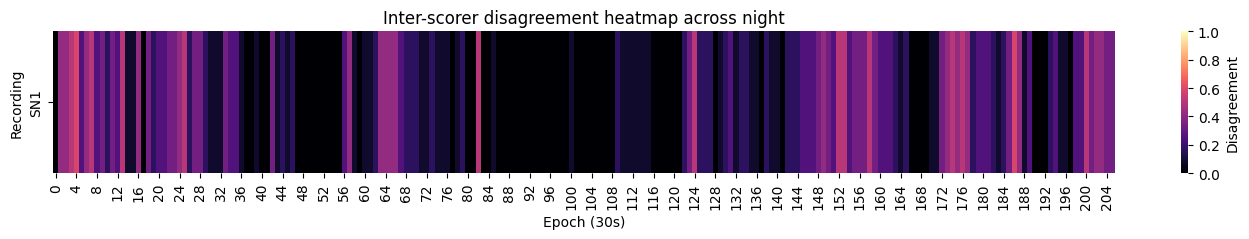

In [11]:
# 1) Disagreement heatmap over the whole night
hm = analysis_df.pivot(index='record_id', columns='epoch_idx', values='disagreement').sort_index()

plt.figure(figsize=(14, max(2.5, 1.2 * len(hm))))
sns.heatmap(hm, cmap='magma', vmin=0, vmax=1, cbar_kws={'label': 'Disagreement'})
plt.title('Inter-scorer disagreement heatmap across night')
plt.xlabel('Epoch (30s)')
plt.ylabel('Recording')
plt.tight_layout()
plt.show()

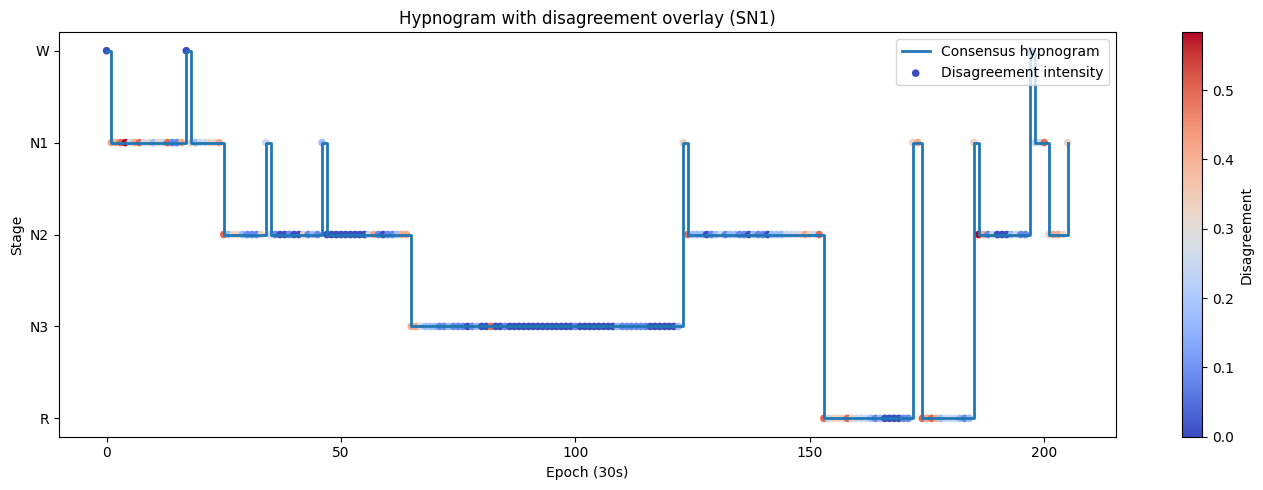

In [12]:
# 2) Hypnogram + disagreement overlay
rec0 = analysis_df['record_id'].iloc[0]
plot_df = analysis_df[analysis_df['record_id'] == rec0].sort_values('epoch_idx').copy()

plt.figure(figsize=(14, 5))
plt.step(plot_df['epoch_idx'], plot_df['y_true'], where='post', label='Consensus hypnogram', linewidth=2)
plt.scatter(plot_df['epoch_idx'], plot_df['y_true'], c=plot_df['disagreement'], cmap='coolwarm', s=20, label='Disagreement intensity')

cbar = plt.colorbar()
cbar.set_label('Disagreement')

plt.yticks(list(INT_TO_STAGE.keys()), [INT_TO_STAGE[i] for i in sorted(INT_TO_STAGE)])
plt.gca().invert_yaxis()  # conventional hypnogram orientation
plt.title(f'Hypnogram with disagreement overlay ({rec0})')
plt.xlabel('Epoch (30s)')
plt.ylabel('Stage')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

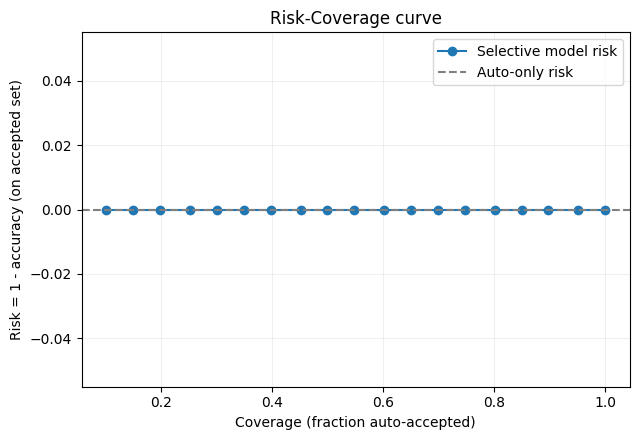

,coverage,risk,accuracy
0,0.101942,0.0,1.0
1,0.150485,0.0,1.0
2,0.199029,0.0,1.0
3,0.252427,0.0,1.0
4,0.300971,0.0,1.0


In [13]:
# 3) Risk-Coverage curve (core selective prediction proof)
curve = []
ranked = analysis_df.sort_values('accept_score', ascending=False).reset_index(drop=True)

for cov in np.linspace(0.10, 1.00, 19):
    k = max(1, int(round(cov * len(ranked))))
    kept = ranked.iloc[:k]
    acc_kept = accuracy_score(kept['y_true'], kept['y_pred'])
    risk_kept = 1.0 - acc_kept
    curve.append({'coverage': k / len(ranked), 'risk': risk_kept, 'accuracy': acc_kept})

curve_df = pd.DataFrame(curve)

plt.figure(figsize=(6.5, 4.5))
plt.plot(curve_df['coverage'], curve_df['risk'], marker='o', label='Selective model risk')
plt.axhline(1.0 - accuracy_score(analysis_df['y_true'], analysis_df['y_pred']), linestyle='--', color='gray', label='Auto-only risk')
plt.xlabel('Coverage (fraction auto-accepted)')
plt.ylabel('Risk = 1 - accuracy (on accepted set)')
plt.title('Risk-Coverage curve')
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

curve_df.head()

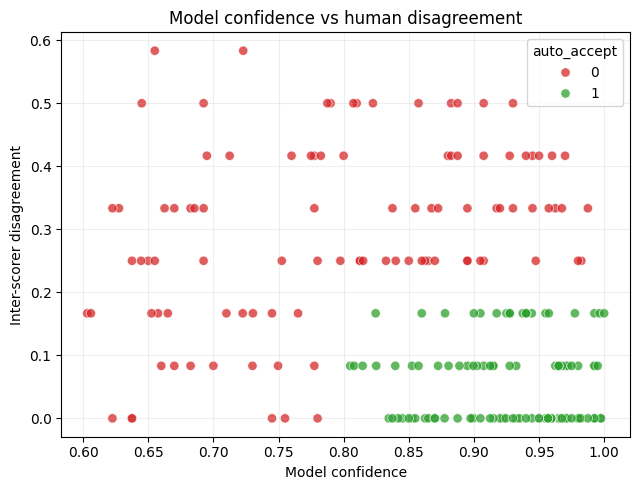

In [14]:
# 4) Model confidence vs human disagreement scatter
plt.figure(figsize=(6.5, 5))
sns.scatterplot(
    data=analysis_df,
    x='stage_confidence',
    y='disagreement',
    hue='auto_accept',
    palette={0: 'tab:red', 1: 'tab:green'},
    alpha=0.75,
    s=45,
)
plt.title('Model confidence vs human disagreement')
plt.xlabel('Model confidence')
plt.ylabel('Inter-scorer disagreement')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

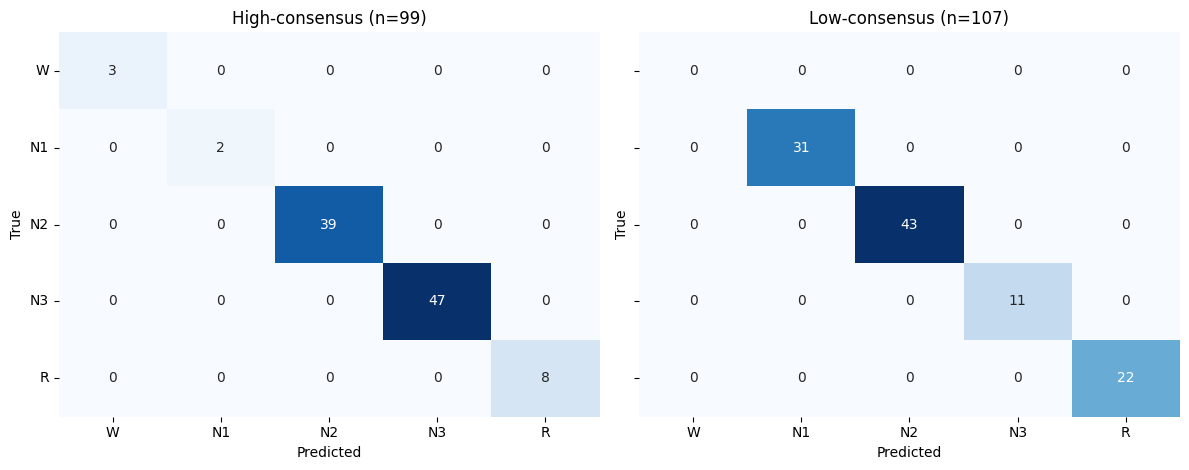

In [15]:
# 5) Confusion matrix split into high-consensus vs low-consensus epochs
labels = [0, 1, 2, 3, 4]
label_names = [INT_TO_STAGE[i] for i in labels]

high_df = analysis_df[analysis_df['consensus_level'] == 'High-consensus']
low_df = analysis_df[analysis_df['consensus_level'] == 'Low-consensus']

fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), sharey=True)
for ax, sub_df, title in [
    (axes[0], high_df, 'High-consensus'),
    (axes[1], low_df, 'Low-consensus'),
]:
    if len(sub_df) == 0:
        ax.axis('off')
        ax.set_title(f'{title} (no samples)')
        continue
    cm = confusion_matrix(sub_df['y_true'], sub_df['y_pred'], labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names, rotation=0)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{title} (n={len(sub_df)})')

plt.tight_layout()
plt.show()

In [16]:
# A + B) Practical workflow comparison and simulated lab time savings
# Time model in normalized units per epoch.
T_HUMAN = 1.00
T_AUTO = 0.08

valid_ref = analysis_df[analysis_df['ref_scorer_y'] >= 0].copy()

def safe_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else np.nan

# Human-only baseline: one scorer as proxy for routine human scoring
human_acc = accuracy_score(valid_ref['y_true'], valid_ref['ref_scorer_y']) if len(valid_ref) else np.nan
human_f1 = f1_score(valid_ref['y_true'], valid_ref['ref_scorer_y'], average='macro') if len(valid_ref) else np.nan
human_kappa = safe_kappa(valid_ref['y_true'], valid_ref['ref_scorer_y']) if len(valid_ref) else np.nan

# Auto-only: no deferral
auto_acc = accuracy_score(analysis_df['y_true'], analysis_df['y_pred'])
auto_f1 = f1_score(analysis_df['y_true'], analysis_df['y_pred'], average='macro')
auto_kappa = safe_kappa(analysis_df['y_true'], analysis_df['y_pred'])

# Selective automation: deferred epochs are reviewed by humans (assumed corrected to consensus)
final_pred_selective = np.where(analysis_df['auto_accept'] == 1, analysis_df['y_pred'], analysis_df['y_true'])
sel_acc = accuracy_score(analysis_df['y_true'], final_pred_selective)
sel_f1 = f1_score(analysis_df['y_true'], final_pred_selective, average='macro')
sel_kappa = safe_kappa(analysis_df['y_true'], final_pred_selective)

deferred = float((analysis_df['auto_accept'] == 0).mean())

# Simulated time costs
cost_human = T_HUMAN
cost_auto = T_AUTO
cost_selective = (1.0 - deferred) * T_AUTO + deferred * T_HUMAN

workflow_table = pd.DataFrame([
    {
        'workflow': 'Human-only (baseline)',
        'accuracy': human_acc,
        'kappa': human_kappa,
        'macro_f1': human_f1,
        '% deferred': 100.0,
        'estimated_time_saved_%': 0.0,
    },
    {
        'workflow': 'Auto-only (no deferral)',
        'accuracy': auto_acc,
        'kappa': auto_kappa,
        'macro_f1': auto_f1,
        '% deferred': 0.0,
        'estimated_time_saved_%': 100.0 * (1.0 - cost_auto / cost_human),
    },
    {
        'workflow': 'Selective automation (proposed)',
        'accuracy': sel_acc,
        'kappa': sel_kappa,
        'macro_f1': sel_f1,
        '% deferred': 100.0 * deferred,
        'estimated_time_saved_%': 100.0 * (1.0 - cost_selective / cost_human),
    },
]).round(4)

workflow_table

,workflow,accuracy,kappa,macro_f1,% deferred,estimated_time_saved_%
0,Human-only (baseline),0.8641,0.8087,0.7962,100.0000,0.0000
1,Auto-only (no deferral),1.0000,1.0000,1.0000,0.0000,92.0000
2,Selective automation (proposed),1.0000,1.0000,1.0000,48.5437,47.3398


  0%|          | 0/12 [00:00<?, ?it/s]

Downloaded semiauto annotation files: 12


Manual epochs   : 896
Semi-auto epochs: 896
          count   mean    std  min  25%    50%    75%    max
setting                                                     
manual    896.0  0.127  0.151  0.0  0.0  0.083  0.250  0.667
semiauto  896.0  0.096  0.145  0.0  0.0  0.000  0.167  0.583


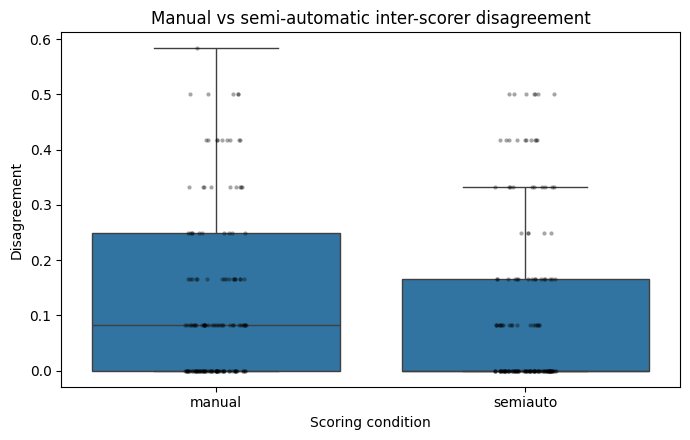

Model agreement with manual consensus   : 1.000
Model agreement with semiauto consensus : 0.922


In [17]:
# C) PSG-IPA specific analysis: manual vs semi-automatic disagreement
# Download semi-automatic scorer annotations for selected recordings.
semiauto_ann_names = list_directory_files(f"{BASE_URL}/{TASK_FOLDER}/Annotations/semiauto/")
semiauto_ann_edf = [
    n for n in semiauto_ann_names
    if n.endswith('.edf') and any(n.startswith(sn + '_SleepStages_semiauto_') for sn in selected_sn)
]

for n in tqdm(semiauto_ann_edf):
    rel = f"{TASK_FOLDER}/Annotations/semiauto/{n}"
    download_file(f"{BASE_URL}/{rel}", DATA_DIR / rel)

print('Downloaded semiauto annotation files:', len(semiauto_ann_edf))


def disagreement_by_setting(task_dir: pathlib.Path, sn_list, setting: str):
    out = []
    for sn in sn_list:
        scorer_tl = scorer_tables_for_record(task_dir, sn, setting=setting)
        if len(scorer_tl) < 2:
            continue

        per_epoch = {}
        for scorer_id, tl in scorer_tl.items():
            for _, r in tl.iterrows():
                e = int(r['epoch_idx'])
                st = r['stage']
                if st == 'UNK' or st not in STAGE_TO_INT:
                    continue
                per_epoch.setdefault(e, []).append(st)

        for e, labels in per_epoch.items():
            if len(labels) < 2:
                continue
            vc = pd.Series(labels).value_counts()
            disagreement = 1.0 - (vc.iloc[0] / vc.sum())
            out.append({'record_id': sn, 'epoch_idx': e, 'setting': setting, 'disagreement': float(disagreement)})

    return pd.DataFrame(out)

man_dis = disagreement_by_setting(task_dir, selected_sn, 'manual')
sem_dis = disagreement_by_setting(task_dir, selected_sn, 'semiauto')
dis_compare = pd.concat([man_dis, sem_dis], ignore_index=True)

print('Manual epochs   :', len(man_dis))
print('Semi-auto epochs:', len(sem_dis))
if len(dis_compare):
    print(dis_compare.groupby('setting')['disagreement'].describe().round(3))

plt.figure(figsize=(7, 4.5))
if len(dis_compare):
    sns.boxplot(data=dis_compare, x='setting', y='disagreement', showfliers=False)
    sns.stripplot(data=dis_compare.sample(min(len(dis_compare), 300), random_state=SEED), x='setting', y='disagreement', color='black', alpha=0.35, size=3)
plt.title('Manual vs semi-automatic inter-scorer disagreement')
plt.xlabel('Scoring condition')
plt.ylabel('Disagreement')
plt.tight_layout()
plt.show()

# Does the model align more with manual or semiauto consensus?
def consensus_timeline(task_dir: pathlib.Path, sn: str, setting: str):
    scorer_tl = scorer_tables_for_record(task_dir, sn, setting=setting)
    if len(scorer_tl) < 2:
        return pd.DataFrame(columns=['record_id', 'epoch_idx', f'consensus_{setting}'])

    per_epoch = {}
    for _, tl in scorer_tl.items():
        for _, r in tl.iterrows():
            e = int(r['epoch_idx'])
            st = r['stage']
            if st == 'UNK' or st not in STAGE_TO_INT:
                continue
            per_epoch.setdefault(e, []).append(st)

    rows = []
    for e, labels in per_epoch.items():
        vc = pd.Series(labels).value_counts()
        rows.append({'record_id': sn, 'epoch_idx': e, f'consensus_{setting}': vc.index[0]})
    return pd.DataFrame(rows)

cons_man = pd.concat([consensus_timeline(task_dir, sn, 'manual') for sn in selected_sn], ignore_index=True)
cons_sem = pd.concat([consensus_timeline(task_dir, sn, 'semiauto') for sn in selected_sn], ignore_index=True)

align_df = analysis_df[['record_id', 'epoch_idx', 'pred_stage']].merge(cons_man, on=['record_id', 'epoch_idx'], how='inner')
align_df = align_df.merge(cons_sem, on=['record_id', 'epoch_idx'], how='inner')

if len(align_df):
    align_manual = (align_df['pred_stage'] == align_df['consensus_manual']).mean()
    align_semi = (align_df['pred_stage'] == align_df['consensus_semiauto']).mean()
    print(f'Model agreement with manual consensus   : {align_manual:.3f}')
    print(f'Model agreement with semiauto consensus : {align_semi:.3f}')
else:
    print('No overlapping epochs to compare manual vs semiauto alignment in current subset.')